In [1]:
# optional but useful for debugging - reimports modules after editing and saving .py files
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import astropy
from astropy import units as u
import astromet
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
print(dir(astromet))

['AU', 'AU_c', 'Delta', 'G', 'Galt', 'Gyr', 'T', 'Time', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'agis', 'agis_2d_prior', 'astromet', 'astropy', 'barycentricPosition', 'binaryMotion', 'bjd_to_bjyr', 'bjyr_to_bjd', 'bodyPos', 'c', 'dThetaEstimate', 'day', 'design_matrix', 'downweight', 'e', 'en_fit', 'findEtas', 'fit', 'fit_model', 'gaia_fit', 'get_gaiat', 'get_obmt', 'kpc', 'lSun', 'mSun', 'mas', 'mas2rad', 'mock_obs', 'name', 'np', 'params', 'period', 'sigString', 'sigmagamma', 'splitFit', 'splitInverse', 'splitNormal', 'track', 'u', 'year']


In [4]:
dr2period=22/12 # in years
edr3Period=34/12 # in years
mas=astromet.mas # conversion from degrees to milli-arcseconds

In [13]:
# times when system is observed [years, CE]
ts=2016+np.sort(edr3Period*(-0.5+np.random.rand(64)))

# an object wich holds all the necessary parameters to find the astrometric path
params=astromet.params()

# For this example we'll generate a random binary system

# center of mass parameters
params.RA=360*np.random.rand()
params.Dec=90*(-1+2*np.random.rand())
print('RA and Dec [degrees]: \n',params.RA,params.Dec)
params.pmRAc=10*np.random.randn()
params.pmDec=10*np.random.randn()
print('Proper motion in RA and Dec [mas/yr]: \n',params.pmRAc,params.pmDec)
params.pllx=1+9*np.random.rand()
print('Parallax [mas]: \n',params.pllx)

# binary parameters
params.M=10*np.random.rand()**2
print('Mass of brightest source [mSun]: \n',params.M)
params.a=10*np.random.rand()
print('Semi-major axis [AU]: \n',params.a)
params.e=np.random.rand()
print('Eccentricity [dimensionless]: \n',params.e)
params.q=0.1#10*(np.random.rand()**4)
params.l=0.05#np.random.rand()
print('Light (l<1) and mass (q) ratios of binary [dimensionless]: \n',params.l,params.q)
params.vPhi=2*np.pi*np.random.rand()
params.vTheta=np.pi*np.random.rand()
print('On-sky projection angles (vPhi and vTheta) of binary [radians]: \n',params.vPhi,params.vTheta)
params.vOmega=2*np.pi*np.random.rand()
print('On-sky orientation angle of binary [radians]: \n',params.vOmega)
params.tPeri=2016+astromet.period(params)*np.random.rand()
print('Time of first binary periapse [years]: \n',params.tPeri)

print('\nPeriod [years]: \n',astromet.period(params))

RA and Dec [degrees]: 
 287.787801058462 68.39899674809665
Proper motion in RA and Dec [mas/yr]: 
 13.882835591939989 5.258359142257896
Parallax [mas]: 
 9.023081530569605
Mass of brightest source [mSun]: 
 1.3915632114321301
Semi-major axis [AU]: 
 5.813805605517242
Eccentricity [dimensionless]: 
 0.9851006268832793
Light (l<1) and mass (q) ratios of binary [dimensionless]: 
 0.05 0.1
On-sky projection angles (vPhi and vTheta) of binary [radians]: 
 0.7093766345808761 0.17596878744658853
On-sky orientation angle of binary [radians]: 
 1.108901060916744
Time of first binary periapse [years]: 
 2023.8565933193595

Period [years]: 
 11.301799540718685


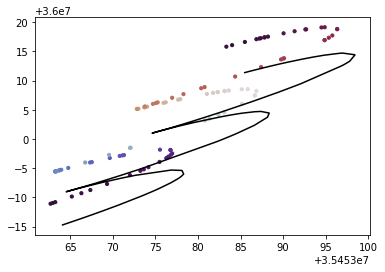

(200,)
weights shape:  (1800,)
x_err shape:  (1800,)
{'astrometric_matched_transits': 200, 'visibility_periods_used': 63, 'astrometric_n_obs_al': 1800, 'astrometric_params_solved': 31, 'ra': -1101960.5028953846, 'ra_error': 196.84715804077317, 'dec': -326297.824458006, 'dec_error': 196.6173124251159, 'ra_dec_corr': 0.002192986692676269, 'parallax': 10696634.13118364, 'parallax_error': 289.7471649676654, 'ra_parallax_corr': -0.060304488239993494, 'dec_parallax_corr': -0.036211274394323256, 'pmra': -9345145.196677973, 'pmra_error': 237.69126151659853, 'ra_pmra_corr': -0.06469964165576599, 'dec_pmra_corr': -0.003565075444736266, 'parallax_pmra_corr': 0.09816838475336077, 'pmdec': -7599008.61531415, 'pmdec_error': 236.55133749805455, 'ra_pmdec_corr': -0.0005354154257082097, 'dec_pmdec_corr': -0.059441165982573985, 'parallax_pmdec_corr': 0.008707558277019339, 'pmra_pmdec_corr': 0.0008662185114181686, 'astrometric_excess_noise': 34625058.00208286, 'astrometric_chi2_al': 1.28496854780302e+19,

NameError: name 'dfvsdfv' is not defined

In [14]:
ts=2016+np.sort(edr3Period*(-0.5+np.random.rand(100)))

params.RA=10#360*np.random.rand()
params.Dec=10#90*(-1+2*np.random.rand())
params.pmRAc=10
params.pmDec=10
params.pllx=10

# on sky paths [degrees]
racs,decs=astromet.track(ts,params,comOnly=True)
cs=mpl.cm.twilight_shifted(np.interp(ts,[ts[0],ts[-1]],[0,1]))

plt.plot(racs,decs,c='k')

racs,decs=astromet.track(ts,params,comOnly=False)

plt.scatter(racs,decs,c=cs,s=10)
plt.show()

phis=360*np.random.rand(ts.size)
talls=np.hstack([ts,ts])
phialls=np.hstack([phis,phis+90])
racalls=np.hstack([racs,racs])
decalls=np.hstack([decs,decs])
erralls=np.hstack([0.3*np.ones(ts.size),np.ones(ts.size)])
xs=astromet.mock_obs(phialls,racalls,decalls,errs=erralls)
print(xs.shape)
results=astromet.gaia_fit(talls,xs,phialls,erralls,params.RA,params.Dec)

print(results)
dfvsdfv

# adding random (1/3 mas) error
astError=1
ras=ras+astError*mas*np.random.randn(ras.size)/np.sqrt(2)
decs=decs+astError*mas*np.random.randn(ras.size)/np.sqrt(2)

# fitting for offset from first obs (delta RA_0 & delta Dec_0), proper motion and parralax
fitParams,fitCovariance=astromet.fit(ts,ras,decs,astError=astError)
print('original parameters [mas(/yr)]: \n',0,0,params.pmRA,params.pmDec,params.pllx)
print('derived parameters [mas(/yr)]: \n',fitParams)
# extracting single parameter errors from covariance matrix
fitErrors=np.sqrt(np.diagonal(fitCovariance))/astError
print('derived parameter error [mas]: \n',fitErrors)
# note that parameters may not agree within error bars due to binary contribution

print('\ncovariance matrix [mas**2]: \n',fitCovariance)


## mistake somewhere in this calibration
## ruwe is sqrt magnitude of covariance matrix normalised by error
#uwe=np.sqrt(np.linalg.norm(fitCovariance))/astError
#print('UWE [dimensionless]: \n',uwe)

print(np.median(ras)/mas+fitParams[0]-params.RA/mas)
print(params.RA)

In [ ]:
print(ras)

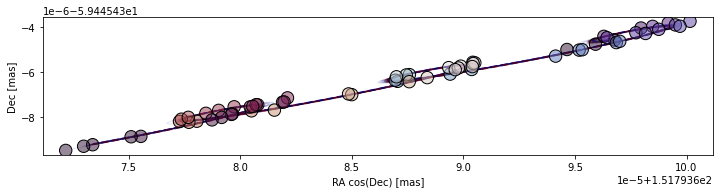

In [372]:
# plotting on sky motion
qFig=plt.figure(figsize=(12,8))
qPl=plt.gca() # defining matplotlib axis object on which to plot

cs=mpl.cm.twilight_shifted(np.interp(ts,[ts[0],ts[-1]],[0,1])) # optional, but I like to color by time
cs[:,3]=0.5

# plotting the datapoints (ideally as error ellipses -
# if that fails comment out the for loop and use the simpler scatter plot instead)
for i in range(ras.size):
    ell = mpl.patches.Ellipse(xy=(ras[i]*np.cos(decs[i]*np.pi/180), decs[i]),
                  width=2*astError*mas, height=2*astError*mas,
                  angle=0)
    ell.set_facecolor(cs[i])
    ell.set_edgecolor('k')
    qPl.add_artist(ell)
#qPl.scatter(ras*np.cos(decs*np.pi/180),decs,s=50,c=cs,zorder=2,edgecolors='k',lw=1)

# uniformly sampled times for plotting true paths
tUniform=np.linspace(ts[0],ts[-1],1000)

# optional - adding the centre of mass motion (black) for reference
comRas,comDecs=astromet.path(tUniform,params,comOnly=True)
qPl.plot(comRas*np.cos(comDecs*np.pi/180),comDecs,lw=1,c='k',alpha=0.5,zorder=1)

# optional - adding the centre of mass motion (red) for reference
trueRas,trueDecs=astromet.path(tUniform,params)
qPl.plot(trueRas*np.cos(trueDecs*np.pi/180),trueDecs,lw=2,c='darkred',alpha=0.5,zorder=1,ls='--')

# optional - adding fitted motion (blue)
for i in range(32):
    sampleParams = np.random.multivariate_normal(fitParams, fitCovariance)
    
    fitPs=astromet.params()
    fitPs.RA=np.median(ras)+mas*sampleParams[0]
    fitPs.Dec=np.median(decs)+mas*sampleParams[1]
    fitPs.pmRA=sampleParams[2]
    fitPs.pmDec=sampleParams[3]
    fitPs.pllx=sampleParams[4]
    bestRas,bestDecs=astromet.path(tUniform,fitPs,comOnly=True)
    qPl.plot(bestRas*np.cos(bestDecs*np.pi/180),bestDecs,lw=1,c='darkblue',alpha=0.1,zorder=0)
fitPs=astromet.params()
fitPs.RA=np.median(ras)+mas*fitParams[0]
fitPs.Dec=np.median(decs)+mas*fitParams[1]
fitPs.pmRA=fitParams[2]
fitPs.pmDec=fitParams[3]
fitPs.pllx=fitParams[4]
bestRas,bestDecs=astromet.path(tUniform,fitPs,comOnly=True)
qPl.plot(bestRas*np.cos(bestDecs*np.pi/180),bestDecs,lw=2,c='darkblue',alpha=0.8,zorder=0,ls='--')

# adding initial position and proper motion as arrow
#qPl.arrow(np.median(ras*np.cos(decs*np.pi/180)),np.median(decs),mas*params.pmRA,mas*params.pmDec,color='k',alpha=0.5)

qPl.set_xlabel('RA cos(Dec) [mas]')
qPl.set_ylabel('Dec [mas]')
qPl.set_aspect('equal')

plt.show()

In [373]:
print('Period: ',astromet.period(params))
print('eccentricity: ',params.e)
uweobs=astromet.uwe(ts,ras,decs,fitParams,astError=1)
print('____________UWE obs: ',uweobs)
dthetapred=astromet.dThetaEstimate(params,ts[0],ts[-1])
print('____________UWE predicted: ',np.sqrt(1+(dthetapred)**2))
dthetasimp=astromet.dThetaEstimate(params,ts[0],ts[0]+params.P)
print('____________UWE simple: ',np.sqrt(1+(dthetasimp)**2))

Period:  3.1434281947297515
eccentricity:  0.8245063389081532
____________UWE obs:  1.0161110129695214
____________UWE predicted:  1.0
____________UWE simple:  1.0
